In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from orangecontrib.bio import ontology

from datasets import (load_non_dubious_orfs, 
                      load_lit_24,
                      load_tarassov, 
                      load_sys_nb,
                      load_y2h_union_08
                      )
from plotting import COLOR_Y2H, COLOR_LIT, COLOR_LIT_NB, COLOR_SYS_NB

In [2]:
mpl.rcParams['font.size'] = 7.
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['savefig.dpi'] = 500

In [3]:
def _load_pairs_excluded_from_our_literature_datasets(lit):
    evid_inc_syst = pd.read_csv('../data/internal/all_curated_PPI_evidence_yeast_24.tsv',
                                low_memory=False,
                                sep='\t')
    evid_inc_syst['date'] = pd.to_datetime(evid_inc_syst['date'])
    
    evid_syst_only = evid_inc_syst.loc[~evid_inc_syst['pair'].isin(lit['pair']), :]

    syst_pairs = evid_syst_only.sort_values('date').drop_duplicates('pair').copy()
    syst_pairs = syst_pairs.loc[:, ['orf_name_a', 'orf_name_b', 'date', 'pair', 'binary']]
    syst_pairs = syst_pairs.rename(columns={'date': 'date_first_pub'})
    syst_pairs['category'] = 'systematic'

    return syst_pairs


def load_all_curated_interactions():
    lit = load_lit_24(include_date=True, remove_homodimers=True)
    lit['pair'] = lit.index
    lit['binary'] = lit['category'].isin(['Lit-BS', 'Lit-BM'])
    syst_pairs = _load_pairs_excluded_from_our_literature_datasets(lit)
    syst_pairs = syst_pairs.set_index('pair')
    syst_pairs['pair'] = syst_pairs.index
    lit = pd.concat([lit, syst_pairs], sort=True).sort_values('date_first_pub')
    lit['binary'] = lit['binary'].astype(bool)
    valid_orfs = load_non_dubious_orfs()
    lit = lit.loc[lit['orf_name_a'].isin(valid_orfs) &
                  lit['orf_name_b'].isin(valid_orfs), :]
    return lit

lit = load_all_curated_interactions()
lit['in_Y2H-union'] = lit.index.isin(load_y2h_union_08(remove_homodimers=True).index)
lit['in_Tarassov'] = lit.index.isin(load_tarassov(remove_homodimers=True).index)
lit['in_APMS'] = lit.index.isin(load_sys_nb(remove_homodimers=True).index)

evid = pd.read_csv('../data/internal/all_curated_PPI_evidence_yeast_24.tsv',
                   low_memory=False,
                   sep='\t')
miOntology = ontology.OBOOntology('../data/external/psi-mi.obo')
affinity_chromatography_terms = set(map(lambda x: x.id,
                       miOntology.sub_terms('MI:0004')))
affinity_chromatography_terms.add('MI:0004')

evid['detection_method'] = 'Other'
evid.loc[evid['y2h'] == 1, 'detection_method'] = 'Y2H'
evid.loc[evid['method_id'].isin(affinity_chromatography_terms),
         'detection_method'] = 'Affinity chromatography'

In [4]:
lit['pair'].nunique()

201115

In [5]:
lit['category'].value_counts(dropna=False)

Lit-NB        157485
systematic     22644
Lit-BS         14684
Lit-BM          6302
Name: category, dtype: int64

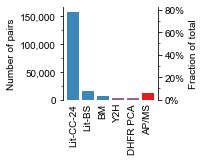

In [6]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=1.7, h=1.7)
ax.bar(
    x=['Lit-CC-24', 'Lit-BS', 'BM', 'Y2H', 'DHFR PCA', 'AP/MS'],
    height=
    [(lit['category'] == 'Lit-NB').sum(),
    (lit['category'] == 'Lit-BS').sum(),
    (lit['category'] == 'Lit-BM').sum(),
    (lit['in_Y2H-union'].sum()),
    (lit['in_Tarassov'].sum()),
    (lit['in_APMS'].sum()),],
    color=[
        COLOR_LIT,
        COLOR_LIT,
        COLOR_LIT,
        COLOR_Y2H,
        COLOR_Y2H,
        COLOR_SYS_NB,
           ],
)
for loc in ['right', 'top', 'bottom']:
    ax.spines[loc].set_visible(False)
ax.xaxis.set_tick_params(length=0, rotation=90)
ax.set_ylabel('Number of pairs')
ax.set_yticks(np.linspace(0, 150000, 4))
ax.set_yticks(np.linspace(0, 150000, 7), minor=True)

ax2 = ax.twinx()
ax2.set_ylabel('Fraction of total')
ax2.set_ylim(0, ax.get_ylim()[1] / lit.shape[0] * 100)
ax2.set_yticks(np.linspace(0, 80, 5))
ax2.set_yticks(np.linspace(0, 70, 8), minor=True)
for loc in ['left', 'top', 'bottom']:
    ax2.spines[loc].set_visible(False)
ax.set_yticklabels([f'{int(y):,}' for y in ax.get_yticks()])
ax2.set_yticklabels([f'{y:.0f}%' for y in ax2.get_yticks()])
fig.savefig('../figures/contribution-to-all-reported-pairs-by-dataset_bar.pdf',
            bbox_inches='tight')


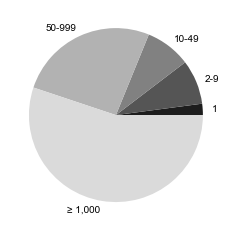

In [7]:
# number of pairs
def bin_n_pairs(n):
    if pd.isnull(n) or n <= 0:
        raise ValueError()
    if n == 1:
        return '1'
    elif n <= 9:
        return '2-9'
    elif n <= 49:
        return '10-49'
    elif n <= 999:
        return '50-999'
    else:
        return '≥ 1,000'

evid['n_pairs_binned'] = evid['n_pairs_per_experiment'].apply(bin_n_pairs)

cmap = plt.cm.Greys_r
dummy_vals = np.linspace(0.1, 0.75, evid['n_pairs_binned'].nunique())
colors = [cmap(v) for v in dummy_vals]

fig, ax = plt.subplots(1, 1)
(evid['n_pairs_binned']
 .value_counts()
 [['1', '2-9', '10-49', '50-999', '≥ 1,000']]
 .plot
 .pie(ax=ax,
      colors=colors,
      ylabel=''))
fig.savefig('../figures/n-pairs-per-experiment_pie.pdf',
            bbox_inches='tight')

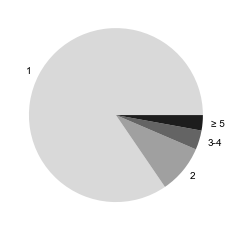

In [8]:
def bin_n_evidence(n):
    if pd.isnull(n) or n <= 0:
        raise ValueError()
    if n == 1:
        return '1'
    elif n == 2:
        return '2'
    elif n <= 4:
        return '3-4'
    else:
        return '≥ 5'


cmap = plt.cm.Greys
dummy_vals = np.linspace(0.25, 0.9, 4)
colors = [cmap(v) for v in dummy_vals]

fig, ax = plt.subplots(1, 1)
(evid
 .groupby('pair')
 .size()
 .apply(bin_n_evidence)
 .value_counts()
 .plot.pie(ax=ax,
          colors=colors,
          ylabel=''))
fig.savefig('../figures/n-evidence-per-pair_pie.pdf',
            bbox_inches='tight')

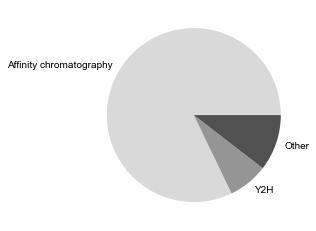

In [9]:
cmap = plt.cm.Greys
dummy_vals = np.linspace(0.25, 0.75, 3)
colors = [cmap(v) for v in dummy_vals]

fig, ax = plt.subplots(1, 1)
(evid['detection_method']
 .value_counts()
 [['Affinity chromatography', 'Y2H', 'Other']]
 .plot.pie(ax=ax,
          colors=colors,
          ylabel=''))
fig.savefig('../figures/method-per-evidence_pie.pdf',
            bbox_inches='tight')